In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm
from scipy.stats import pearsonr
from itertools import chain
import statsmodels.api as sm
import statsmodels.formula.api as smf
import cftime

# 1. Climate Teleco Maps

In [ ]:

enso3 = pd.read_csv("../processed data/cook2024-R15-ENSO-Rec-1500-2000.txt", delimiter="\t", comment="#", na_values="NA")
lat_lon = pd.read_csv("../processed data/cook2024-ENSO-latlon.txt", delimiter="\t", comment="#", na_values="NA")

# Melt the ENSO DataFrame to long format
enso_melted = enso3.melt(id_vars=["Year"], var_name="gridpoint", value_name="enso")
enso_melted["gridpoint"] = enso_melted["gridpoint"].astype(int)

# Merge with the lat/lon DataFrame
enso_merged = enso_melted.merge(lat_lon, on="gridpoint")

# Convert to xarray
enso_xr = enso_merged.set_index(["Year", "lat", "lon"])["enso"].to_xarray()

#enso_xr = enso_xr - enso_xr.sel(Year=slice(1800, 1850)).mean(dim="Year")

enso_xr = enso_xr- enso_xr.rolling(Year=50, min_periods=1).mean()

nino3 = enso_xr.sel(lat=slice(-5, 5), lon=slice(-150, -90)).mean(dim=["lat", "lon"])
nino34 = enso_xr.sel(lat=slice(-5, 5), lon=slice(-170, -120)).mean(dim=["lat", "lon"])
nino4 = enso_xr.sel(lat=slice(-5, 5), lon = slice(-200, -150)).mean(dim=["lat", "lon"])
nino12 = enso_xr.sel(lat=slice(-10, 0), lon=slice(-90, -80)).mean(dim=["lat", "lon"])


enso = nino3.to_dataframe().reset_index().rename(columns={"enso": "nino3"})
enso = pd.merge(enso, nino34.to_dataframe().reset_index().rename(columns={"enso": "nino34"}), on="Year")
enso = pd.merge(enso, nino4.to_dataframe().reset_index().rename(columns={"enso": "nino4"}), on="Year")
enso = pd.merge(enso, nino12.to_dataframe().reset_index().rename(columns={"enso": "nino12"}), on="Year")

enso = enso[enso['Year'] <=1800]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from scipy.stats import pearsonr, spearmanr, kendalltau

def plot_correlation_maps_with_significance(temp_xr, nino_dict, title, alpha=0.1, threshold=0.1,
                                            cmap='RdBu_r',
                                             projection=ccrs.EuroPP()):
    """
    temp_xr: xarray.DataArray of shape (time, lat, lon)
    nino_dict: dict of {nino_name: xarray.DataArray of shape (time,)}
    """
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"projection": projection})

    levels = np.linspace(-0.2, 0.2, 9)
    cmap = plt.get_cmap(cmap)
    norm = BoundaryNorm(levels, ncolors=cmap.N)

    lon = temp_xr['longitude'].values
    lat = temp_xr['latitude'].values
    lon2d, lat2d = np.meshgrid(lon, lat)

    for ax, (nino_name, nino_series) in zip(axes.flat, nino_dict.items()):
        corr_vals = np.full((len(lat), len(lon)), np.nan)
        p_vals = np.full_like(corr_vals, np.nan)

        # Loop over each gridpoint
        for i in range(len(lat)):
            for j in range(len(lon)):
                temp_ts = temp_xr[:, i, j].values
                nino_ts = nino_series.values

                mask = np.isfinite(temp_ts) & np.isfinite(nino_ts)
                if mask.sum() > 10:
                    r, p = pearsonr(temp_ts[mask], nino_ts[mask])
                    corr_vals[i, j] = r
                    p_vals[i, j] = p

        # Plot correlation
        im = ax.pcolormesh(
            lon2d, lat2d, corr_vals,
            transform=ccrs.PlateCarree(),
            cmap=cmap, norm=norm
        )



        # Scatter gray for weak correlation (|r| < threshold)
        weak_mask = p_vals <= alpha
        ax.scatter(
            lon2d[weak_mask], lat2d[weak_mask], s=4, color='black',
            transform=ccrs.PlateCarree(), label=f'p-val < {alpha}'
        )

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_extent([-10, 35, 36, 70], crs=ccrs.PlateCarree())
        ax.set_title(f"Correlation with {nino_name.upper()}", fontsize=11)

        cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label("Correlation", fontsize=10)
        cbar.set_ticks(levels)

        ax.legend(loc='lower right', fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"../figures/plots/{title}_telecomap.pdf", dpi=300, bbox_inches='tight')
    plt.show()


# Temp

In [ ]:
xds = xr.open_dataset('../processed data/ModE-RA_ensmean_temp2_anom_wrt_1901-2000_1421-2008_mon.nc')

# Extract year and filter by given range
xds = xds.assign(Year=xds.time.dt.year)
#select 1500-1800
xds = xds.sel(time=slice("1500-01-01", "1800-12-31"))

# Apply latitude weighting
xds['temp'] = np.sqrt(np.cos(np.deg2rad(xds['latitude'])) + 1e-6) * (xds['temp2'])

# Define seasons
winter_months = [11, 12, 1, 2]
summer_months = [4, 5, 6, 7]

def shift_decembers(time_array):
    return [cftime.DatetimeGregorian(t.year + 1, t.month, t.day) if t.month in [11, 12] else t for t in time_array]


#xds = xds.assign_coords(time=("time", shift_decembers(xds.time.values)))


# --- **(2) Compute European Domain-Average Temperatures** ---
# Define European bounding box (adjust as needed)
lat_bounds = (70, 35)   # Latitude range for Europe
lon_bounds = (-15, 35)  # Longitude range for Europe

# Subset dataset to Europe only
xds_europe = xds.sel(latitude=slice(*lat_bounds), longitude=slice(*lon_bounds))

C:\Users\emile\AppData\Local\Temp\ipykernel_15324\623492212.py:1: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  xds = xr.open_dataset('data/ModE-RA_ensmean_temp2_anom_wrt_1901-2000_1421-2008_mon.nc')


In [5]:
# Ensure "Year" is the index in enso dataframe
nino_xr = xr.Dataset.from_dataframe(enso.set_index("Year"))
winter_months = [11, 12,1, 2]
summer_months = [5, 6, 7, 8]
# Select winter and summer months, then group by Year and average
xds_europe_winter = xds_europe.sel(time=xds_europe.time.dt.month.isin(winter_months)).groupby("Year").mean(dim="time")
xds_europe_summer = xds_europe.sel(time=xds_europe.time.dt.month.isin(summer_months)).groupby("Year").mean(dim="time")

# Merge temp data with ENSO indices once
data_merged_winter = xr.merge([xds_europe_winter, nino_xr])
data_merged_summer = xr.merge([xds_europe_summer, nino_xr])

# List of Niño indices to process
nino_indices = ["nino3", "nino34", "nino4", "nino12"]

# Compute correlations efficiently
corr_winter = {var: xr.corr(data_merged_winter["temp"], data_merged_winter[var], dim="Year") for var in nino_indices}
corr_summer = {var: xr.corr(data_merged_summer["temp"], data_merged_summer[var], dim="Year") for var in nino_indices}


c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\xarray\structure\concat.py:547: UserWarning: No index created for dimension Year because variable Year is not a coordinate. To create an index for Year, please first call `.set_coords('Year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\xarray\structure\concat.py:547: UserWarning: No index created for dimension Year because variable Year is not a coordinate. To create an index for Year, please first call `.set_coords('Year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


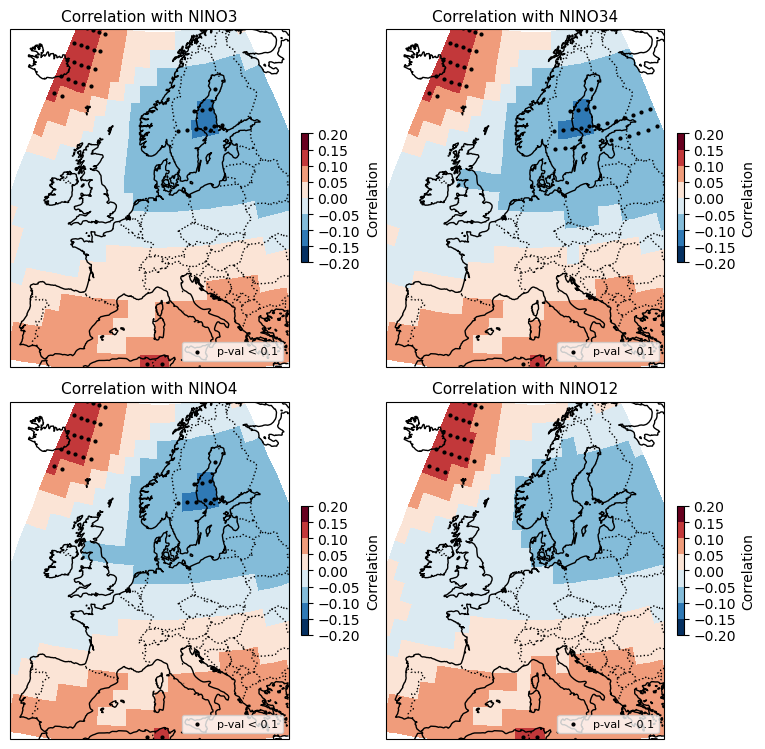

In [6]:
nino_indices = ["nino3", "nino34", "nino4", "nino12"]

# Example for winter season
nino_dict = {k: data_merged_winter[k] for k in nino_indices}
temp_xr = data_merged_winter["temp"]  # shape: (time, lat, lon)

plot_correlation_maps_with_significance(
    temp_xr=temp_xr,
    nino_dict=nino_dict,
    title="wintertemp",
    alpha=0.1
)



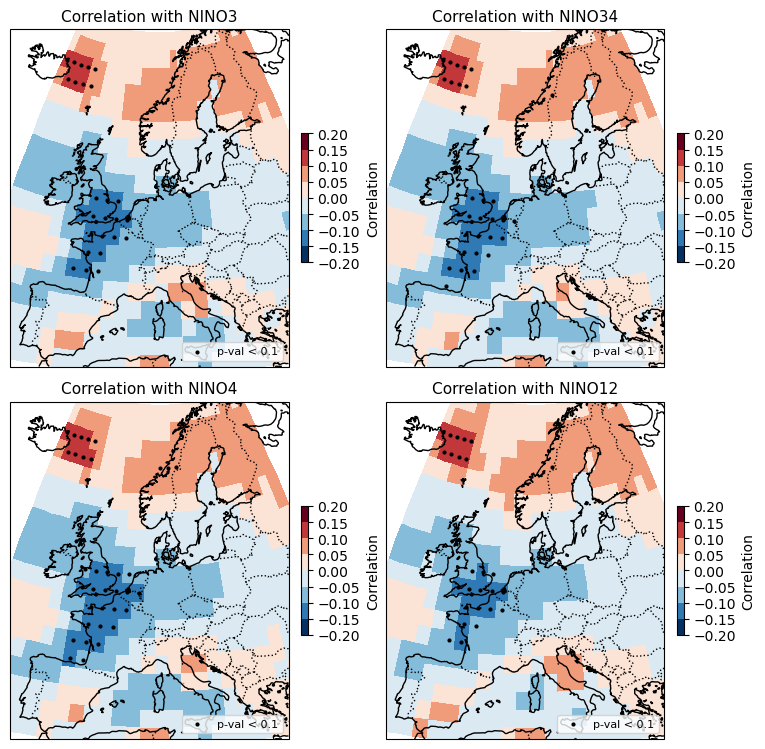

In [7]:

# Example for winter season
nino_dict = {k: data_merged_summer[k] for k in nino_indices}
temp_xr = data_merged_summer["temp"]  # shape: (time, lat, lon)

plot_correlation_maps_with_significance(
    temp_xr=temp_xr,
    nino_dict=nino_dict,
    title="summertemp",
    alpha=0.1
)

# Precip

In [ ]:
# Load dataset
xds_p = xr.open_dataset('../processed data/ModE-RA_ensmean_totprec_anom_wrt_1901-2000_1421-2008_mon.nc')

# Extract year and filter by given range
xds_p = xds_p.assign(Year=xds_p.time.dt.year)
#select 1500-1800
xds_p = xds_p.sel(time=slice("1500-01-01", "1800-12-31"))

def shift_decembers(time_array):
    return [cftime.DatetimeGregorian(t.year + 1, t.month, t.day) if t.month in [11, 12] else t for t in time_array]

xds_p = xds_p.assign_coords(time=("time", shift_decembers(xds_p.time.values)))

# Apply latitude weighting
xds_p['precip'] = np.sqrt(np.cos(np.deg2rad(xds_p['latitude'])) + 1e-6) * xds_p['totprec']*86400*30


#xds_p = xds_p.assign_coords(time=("time", shift_decembers(xds_p.time.values)))

# --- **(2) Compute European Domain-Average preciperatures** ---
# Define European bounding box (adjust as needed)
lat_bounds = (70, 35)   # Latitude range for Europe
lon_bounds = (-15, 35)  # Longitude range for Europe

# Subset dataset to Europe only
xds_p_europe = xds_p.sel(latitude=slice(*lat_bounds), longitude=slice(*lon_bounds))



C:\Users\emile\AppData\Local\Temp\ipykernel_15324\3853498079.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  xds_p = xr.open_dataset('data/ModE-RA_ensmean_totprec_anom_wrt_1901-2000_1421-2008_mon.nc')


In [9]:
# Ensure "Year" is the index in enso dataframe
nino_xr = xr.Dataset.from_dataframe(enso.set_index("Year"))
winter_months = [11, 12, 1, 2]
summer_months = [4,5,6,7]
# Select winter and summer months, then group by Year and average
xds_europe_winter_p = xds_p_europe.sel(time=xds_p_europe.time.dt.month.isin(winter_months)).groupby("Year").mean(dim="time")
xds_europe_summer_p = xds_p_europe.sel(time=xds_p_europe.time.dt.month.isin(summer_months)).groupby("Year").mean(dim="time")

# Merge temp data with ENSO indices once
data_merged_winter_p = xr.merge([xds_europe_winter_p, nino_xr])
data_merged_summer_p = xr.merge([xds_europe_summer_p, nino_xr])

# List of Niño indices to process
nino_indices = ["nino3", "nino34", "nino4", "nino12"]

# Compute correlations efficiently
corr_winter_p = {var: xr.corr(data_merged_winter_p["precip"], data_merged_winter_p[var], dim="Year") for var in nino_indices}
corr_summer_p = {var: xr.corr(data_merged_summer_p["precip"], data_merged_summer_p[var], dim="Year") for var in nino_indices}



c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\xarray\structure\concat.py:547: UserWarning: No index created for dimension Year because variable Year is not a coordinate. To create an index for Year, please first call `.set_coords('Year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\xarray\structure\concat.py:547: UserWarning: No index created for dimension Year because variable Year is not a coordinate. To create an index for Year, please first call `.set_coords('Year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


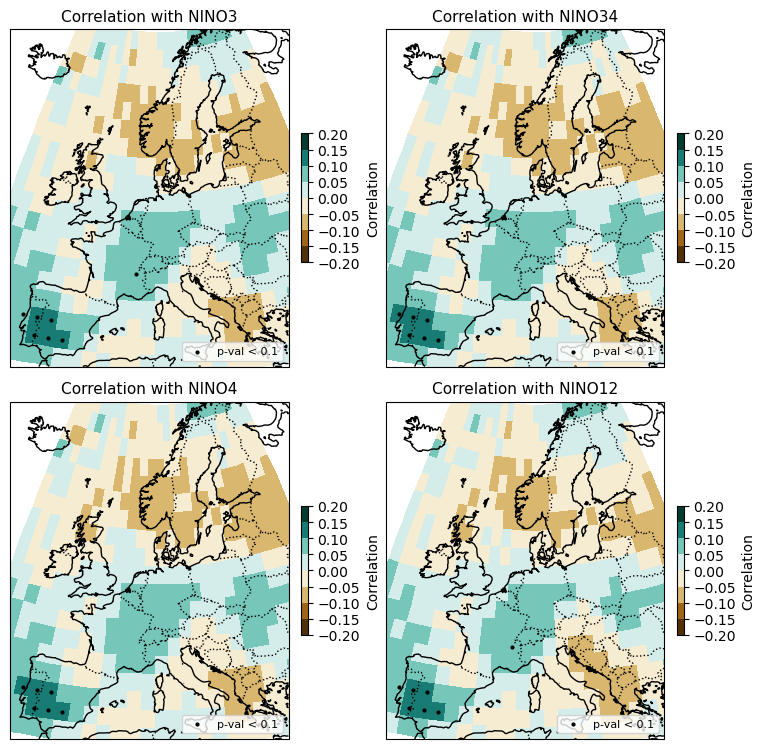

In [10]:
nino_indices = ["nino3", "nino34", "nino4", "nino12"]

# Example for winter season
nino_dict = {k: data_merged_winter_p[k] for k in nino_indices}
precip_xr = data_merged_winter_p["precip"]  # shape: (time, lat, lon)

plot_correlation_maps_with_significance(
    temp_xr=precip_xr,
    nino_dict=nino_dict,
    title="winterprecip",
    cmap='BrBG',
    alpha=0.1
)

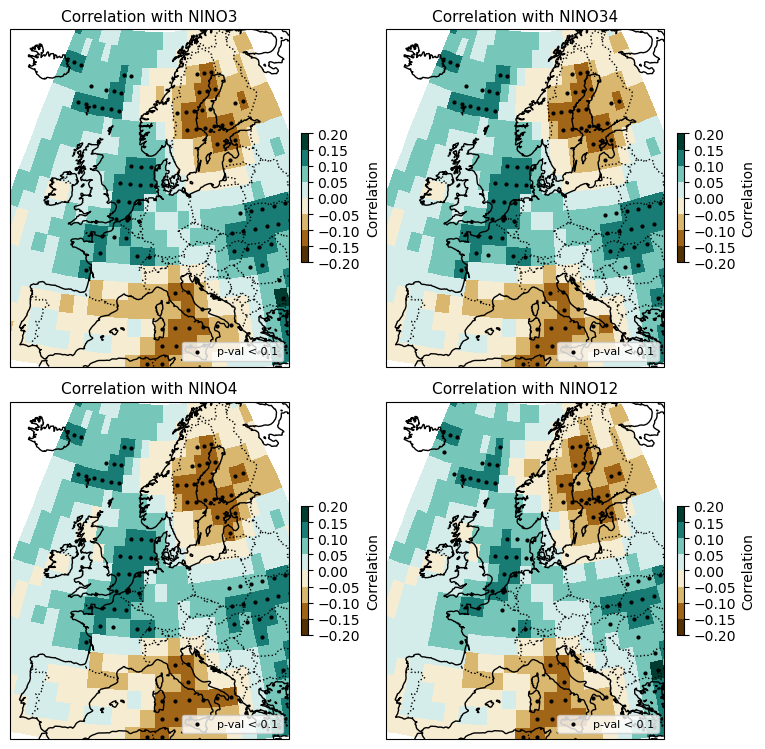

In [11]:
nino_indices = ["nino3", "nino34", "nino4", "nino12"]

# Example for winter season
nino_dict = {k: data_merged_summer_p[k] for k in nino_indices}
precip_xr = data_merged_summer_p["precip"]  # shape: (time, lat, lon)

plot_correlation_maps_with_significance(
    temp_xr=precip_xr,
    nino_dict=nino_dict,
    title="summerprecip",
    cmap='BrBG',
    alpha=0.1
)

# PDSI

In [ ]:
# Load dataset
owda = xr.open_dataset("../processed data/owda.nc")

# Compute latitude-weighted PDSI
owda["PDSI_weighted"] = np.sqrt(np.cos(np.deg2rad(owda["lat"])) + 1e-6) * owda["pdsi"]
# change time to year
owda = owda.assign_coords(Year=owda.time).swap_dims({"time": "Year"})
# Select the years of interest
owda = owda.sel(Year=slice(1500, 1800))

lat_bounds = (35, 70)   # Latitude range for Europe
lon_bounds = (-15, 35)  # Longitude range for Europe

owda = owda.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))
owda = owda.rename({'lat': 'latitude', 'lon': 'longitude'})


In [13]:
# Ensure "Year" is the index in enso dataframe
nino_xr = xr.Dataset.from_dataframe(enso.set_index("Year"))

# Merge temp data with ENSO indices once
data_merged_pdsi = xr.merge([owda, nino_xr])

# List of Niño indices to process
nino_indices = ["nino3", "nino34", "nino4", "nino12"]

# Compute correlations efficiently
corr_pdsi = {var: xr.corr(data_merged_pdsi["PDSI_weighted"], data_merged_pdsi[var], dim="Year") for var in nino_indices}



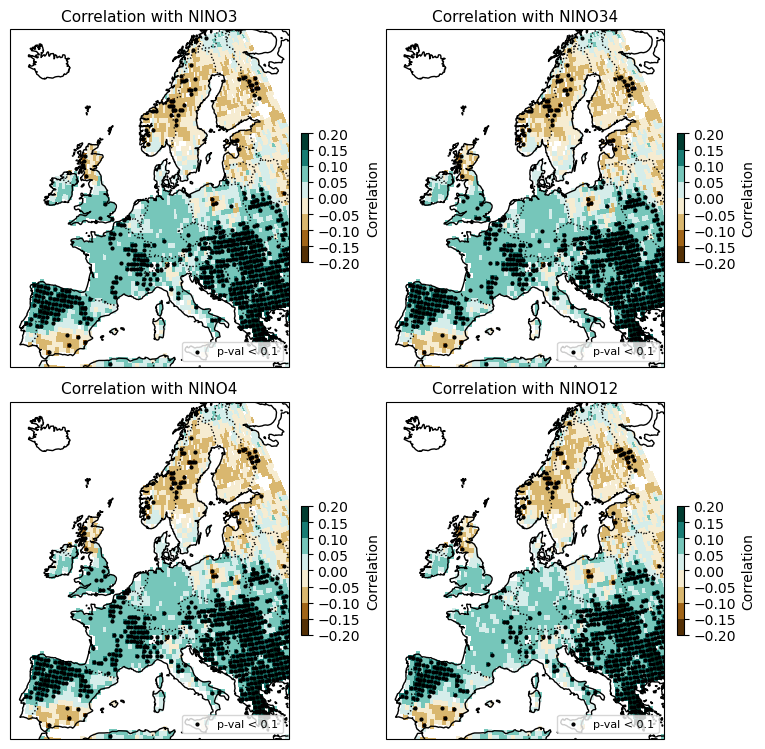

In [14]:
nino_indices = ["nino3", "nino34", "nino4", "nino12"]

# Example for winter season
nino_dict = {k: data_merged_pdsi[k] for k in nino_indices}
pdsi_xr = data_merged_pdsi["PDSI_weighted"].transpose('Year','latitude','longitude')  # shape: (time, lat, lon)

plot_correlation_maps_with_significance(
    temp_xr=pdsi_xr,
    nino_dict=nino_dict,
    title="PDSI",
    cmap='BrBG',
    alpha=0.1
)

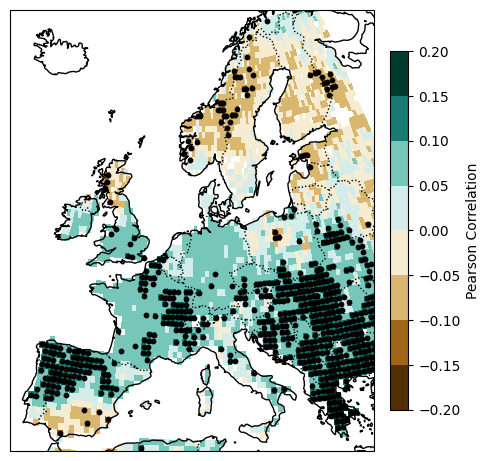

In [ ]:
# Set parameters
alpha = 0.1  # significance threshold
levels = np.linspace(-0.2, 0.2, 9)
cmap = plt.get_cmap('BrBG')
norm = BoundaryNorm(levels, ncolors=cmap.N)

# Time period
year_range = slice(1500, 1800)

# Subset data
pdsi = data_merged_pdsi["PDSI_weighted"].transpose("Year", "latitude", "longitude").sel(Year=year_range)
nino = data_merged_pdsi["nino34"].sel(Year=year_range)

# Coordinates
lon = pdsi["longitude"].values
lat = pdsi["latitude"].values
lon2d, lat2d = np.meshgrid(lon, lat)

# Initialize correlation and p-value arrays
corr_vals = np.full((len(lat), len(lon)), np.nan)
p_vals = np.full_like(corr_vals, np.nan)

# Compute correlation grid-wise
for i in range(len(lat)):
    for j in range(len(lon)):
        pdsi_ts = pdsi[:, i, j].values
        nino_ts = nino.values
        mask = np.isfinite(pdsi_ts) & np.isfinite(nino_ts)
        if mask.sum() > 10:
            r, p = pearsonr(pdsi_ts[mask], nino_ts[mask])
            corr_vals[i, j] = r
            p_vals[i, j] = p

# --- Plot ---
fig = plt.figure(figsize=(5, 10))
ax = plt.subplot(1, 1, 1, projection=ccrs.EuroPP())

# Correlation map
im = ax.pcolormesh(
    lon2d, lat2d, corr_vals,
    cmap=cmap, norm=norm, shading="auto",
    transform=ccrs.PlateCarree()
)

# Significance mask
sig_mask = p_vals <= alpha
ax.scatter(
    lon2d[sig_mask], lat2d[sig_mask], s=10, color='black',
    label=f'p < {alpha}', transform=ccrs.PlateCarree()
)

# Map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_extent([-10, 35, 36, 70], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# Colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label("Pearson Correlation")

# Save or show
plt.tight_layout()
plt.savefig("../figures/plots/teleco_PDSI_main.pdf", dpi=300, bbox_inches="tight")
plt.show()

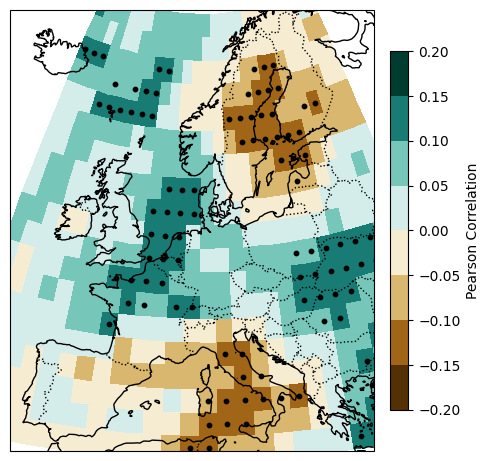

In [ ]:
# Set parameters
alpha = 0.1  # significance threshold
levels = np.linspace(-0.2, 0.2, 9)
cmap = plt.get_cmap('BrBG')
norm = BoundaryNorm(levels, ncolors=cmap.N)

# Time period
year_range = slice(1500, 1800)

# Subset data
pdsi = data_merged_summer_p["precip"].transpose("Year", "latitude", "longitude").sel(Year=year_range)
nino = data_merged_summer_p["nino34"].sel(Year=year_range)

# Coordinates
lon = pdsi["longitude"].values
lat = pdsi["latitude"].values
lon2d, lat2d = np.meshgrid(lon, lat)

# Initialize correlation and p-value arrays
corr_vals = np.full((len(lat), len(lon)), np.nan)
p_vals = np.full_like(corr_vals, np.nan)

# Compute correlation grid-wise
for i in range(len(lat)):
    for j in range(len(lon)):
        pdsi_ts = pdsi[:, i, j].values
        nino_ts = nino.values
        mask = np.isfinite(pdsi_ts) & np.isfinite(nino_ts)
        if mask.sum() > 10:
            r, p = pearsonr(pdsi_ts[mask], nino_ts[mask])
            corr_vals[i, j] = r
            p_vals[i, j] = p

# --- Plot ---
fig = plt.figure(figsize=(5, 10))
ax = plt.subplot(1, 1, 1, projection=ccrs.EuroPP())

# Correlation map
im = ax.pcolormesh(
    lon2d, lat2d, corr_vals,
    cmap=cmap, norm=norm, shading="auto",
    transform=ccrs.PlateCarree()
)

# Significance mask
sig_mask = p_vals <= alpha
ax.scatter(
    lon2d[sig_mask], lat2d[sig_mask], s=10, color='black',
    label=f'p < {alpha}', transform=ccrs.PlateCarree()
)

# Map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_extent([-10, 35, 36, 70], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# Colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label("Pearson Correlation")

# Save or show
plt.tight_layout()
plt.savefig("../figures/plots/teleco_summerP_main.pdf", dpi=300, bbox_inches="tight")
plt.show()

# 2. Prices/Yields Maps

In [ ]:
prices = pd.read_csv('../processed data/price_2023_enso.csv')
yields = pd.read_csv('../processed data/yield_ljungqvist_2025.csv').rename(columns={"lat": "Latitude", "lon": "Longitude"})
fishprices = pd.read_csv('../processed data/fishprice_enso.csv')


In [ ]:
def plot_teleconnection_map(df, teleco_col, title=None, marker_size=5):
    fig = plt.figure(figsize=(6, 8))
    ax = plt.axes(projection=ccrs.EuroPP())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='white')

    # Plot non-teleconnected points (0)
    if teleco_col is not None: 
        df0 = df[df[teleco_col] == 0]
        ax.scatter(df0['Longitude'], df0['Latitude'], color='black', s=marker_size,
                label='Not Teleconnected', alpha=0.7, transform=ccrs.PlateCarree())

        # Plot teleconnected points (1)
        df1 = df[df[teleco_col] == 1]
        ax.scatter(df1['Longitude'], df1['Latitude'], color='red', s=marker_size,
                label='Teleconnected', alpha=0.8, transform=ccrs.PlateCarree())

        plt.legend()

        plt.savefig(f'../figures/plots/map_{title}_{teleco_col}.png', dpi=300)

    else:

        ax.scatter(df['Longitude'], df['Latitude'], color='red', s=marker_size, alpha=0.8, transform=ccrs.PlateCarree())

        plt.legend()

        plt.savefig(f'../figures/plots/map_{title}.png', dpi=300)

    plt.show()

C:\Users\emile\AppData\Local\Temp\ipykernel_9436\2231855523.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


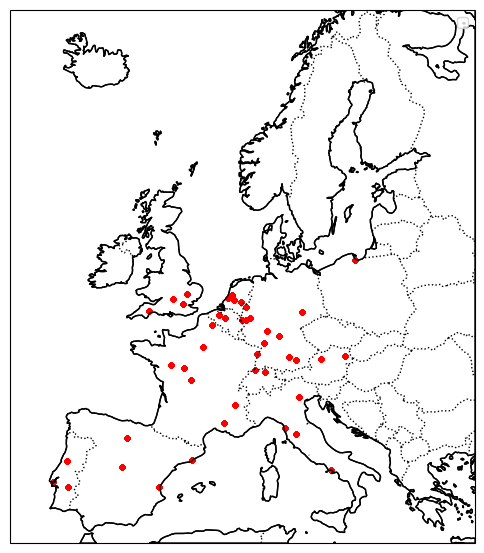

C:\Users\emile\AppData\Local\Temp\ipykernel_9436\2231855523.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


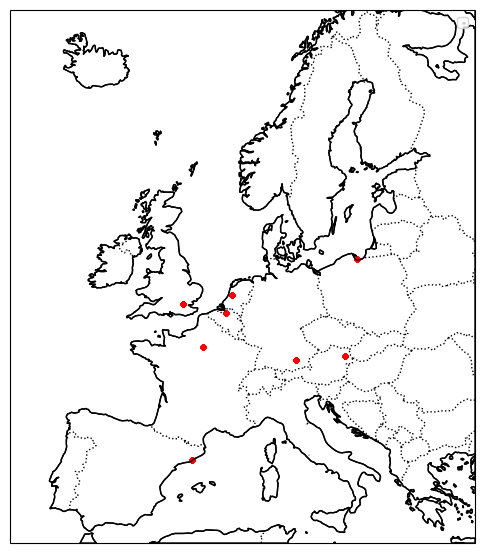

C:\Users\emile\AppData\Local\Temp\ipykernel_9436\2231855523.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


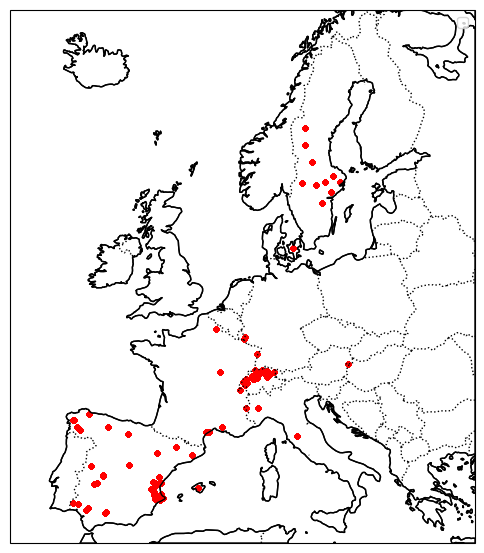

In [17]:
plot_teleconnection_map(
    prices,
    teleco_col=None,
    title='grainprices',
    marker_size=10
)

plot_teleconnection_map(
    fishprices,
    teleco_col=None,
    title='fishprices',
    marker_size=10
)

plot_teleconnection_map(
    yields,
    teleco_col=None,
    title='grainyields',
    marker_size=10
)